In [18]:
import pickle as pkl
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
from voltron.data import make_ticker_list, GetStockHistory

sns.set_style('white')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

In [19]:
def ECDF(sample_pxs, true_px):    
    return (torch.sum(sample_pxs < true_px, 0)/sample_pxs.shape[0])
 
def Calibration(pcts, percentile=0.95):
    in_band = np.where((pcts < percentile))[0].shape[0]
    return in_band/pcts.shape[0]

def GetCalibration(model, mean='ewma', k=100, horizon=np.arange(75,100), 
                   logger=[], exp=True):
    

    ntrain = 400
    n_test_times = 20
    ntest = 100
    pcts = torch.tensor([])
    for tckr in ticker_list[:5]:
        data = GetStockHistory(tckr, history=1000, end_date=end_date)
        for idx, date in enumerate(data.index):

            fpath = "./saved-outputs/"+ tckr + "/"
            fname = model + "_"
            if model == 'volt':
                fname +=  mean + str(k) + "_"

            fname += str(date.date()) + ".pt"


            if os.path.exists(fpath + fname): 
                preds = torch.load(fpath + fname).cpu()
                if isinstance(preds, tuple):
                    preds = preds[0]

                preds = preds[:, horizon]

                test_y = torch.tensor(data.iloc[idx:idx+100].Close.to_numpy())
                if test_y.shape[0] == 100:
                    if exp:
                        preds = preds.exp()
                    pcts = torch.cat((pcts, ECDF(preds, test_y[horizon])))
            
    if pcts.numel() == 0:
        return logger
    
    pcts = pcts.flatten().numpy()
    percentiles = np.linspace(0.05, 0.95, 19)
    for pct in percentiles:
        clb = Calibration(pcts, pct)
        logger.append([clb, np.round(pct, 2), model, mean, k])
        
    return logger

In [20]:
data_path = "../../voltron/data/"
ticker_list = make_ticker_list(data_path + "test_tickers.txt")

In [21]:
logger = []
end_date = "2022-01-13"
tckr = ticker_list[0]
data = GetStockHistory(tckr, history=1000, end_date=end_date)

In [22]:
log = GetCalibration('gpcv', horizon=np.arange(75,100), 
                       logger=[], exp=True)

In [23]:
log

[[0.0032876712328767125, 0.05, 'gpcv', 'ewma', 100],
 [0.006575342465753425, 0.1, 'gpcv', 'ewma', 100],
 [0.009863013698630137, 0.15, 'gpcv', 'ewma', 100],
 [0.009863013698630137, 0.2, 'gpcv', 'ewma', 100],
 [0.010958904109589041, 0.25, 'gpcv', 'ewma', 100],
 [0.01315068493150685, 0.3, 'gpcv', 'ewma', 100],
 [0.020821917808219178, 0.35, 'gpcv', 'ewma', 100],
 [0.04547945205479452, 0.4, 'gpcv', 'ewma', 100],
 [0.09917808219178083, 0.45, 'gpcv', 'ewma', 100],
 [0.16383561643835617, 0.5, 'gpcv', 'ewma', 100],
 [0.24493150684931506, 0.55, 'gpcv', 'ewma', 100],
 [0.3150684931506849, 0.6, 'gpcv', 'ewma', 100],
 [0.38904109589041097, 0.65, 'gpcv', 'ewma', 100],
 [0.44767123287671234, 0.7, 'gpcv', 'ewma', 100],
 [0.5090410958904109, 0.75, 'gpcv', 'ewma', 100],
 [0.581917808219178, 0.8, 'gpcv', 'ewma', 100],
 [0.6547945205479452, 0.85, 'gpcv', 'ewma', 100],
 [0.7682191780821918, 0.9, 'gpcv', 'ewma', 100],
 [0.8936986301369862, 0.95, 'gpcv', 'ewma', 100]]

In [5]:
log = []

for k in [25, 50, 100, 200, 300, 400]:
    for mean in ['ewma', 'dewma', 'tewma']:
        log = GetCalibration('volt', mean=mean, k=k, horizon=np.arange(75,100), 
                       logger=log, exp=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-43a8e5b361f3>", line 5, in <module>
    log = GetCalibration(tckr, 'volt', mean=mean, k=k, horizon=np.arange(75,100),
  File "<ipython-input-2-2db4e6563d03>", line 17, in GetCalibration
    data = GetStockHistory(tckr, history=1000, end_date=end_date)
  File "/home/greg_b/voltron/voltron/data/MakeData.py", line 39, in GetStockHistory
    data = yf.download(tickers=ticker, period='10y', progress=False)
  File "/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/yfinance/multi.py", line 112, in download
    _time.sleep(0.01)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/IPython/core/interactiveshell

TypeError: object of type 'NoneType' has no len()

In [24]:
df = pd.DataFrame(log)
df.columns = ['Calibration', 'Percentile', "Model", "Mean", "k"]

In [25]:
# pd.to_pickle(df, "./volt_calib.pkl")

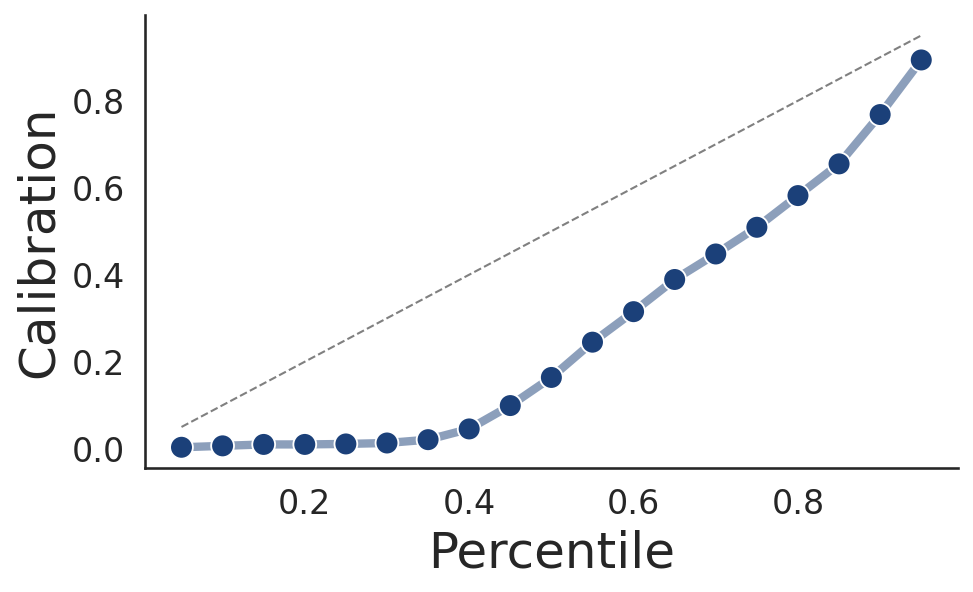

In [28]:
def PlotCalib(df, ax, title):
    sub_df = df[df['k'] == 100]
    pal = [ palette[0]]#, palette[4], palette[6]]
    sns.lineplot(x='Percentile', y="Calibration", hue='Mean', data=sub_df, ax=ax, alpha=0.5,
                palette=pal, legend=False)
    sns.scatterplot(x='Percentile', y="Calibration", hue='Mean', data=sub_df, ax=ax, s=120, legend=False, zorder=4,
                   palette=pal)
    x = np.linspace(0.05,0.95)
    y = np.linspace(0, len(percentiles))
    ax.plot(x, x, color="gray", lw=1., ls="--")
#     ax.set_title(title)


from matplotlib.lines import Line2D
fig, ax = plt.subplots(1,1,dpi=150, figsize=(7, 4))

percentiles = np.linspace(0.05, 0.95, 19)
PlotCalib(df, ax, "Wind Speed Calibration")


plt.tick_params(labelsize=16)
sns.despine()

# custom_lines = [Line2D([0], [0], color=palette[0], lw=2),
#                Line2D([0], [0], color=palette[4], lw=2),
#                Line2D([0], [0], color=palette[6], lw=2)]


# plt.legend(custom_lines, ['LSTM', r"GP-Matérn", "Volt + Magpie"],
#            fontsize=14, frameon=False, bbox_to_anchor=(0.45, 0.6))
# ax.legend(fontsize=14, bbox_to_anchor=(1., 0.75))
# plt.label("Percentile")
# plt.savefig("./wind_calibration.pdf", bbox_inches="tight")
plt.show()

In [18]:
data = GetStockHistory('ATVI', history=1000, end_date='2020-05-14')
preds = torch.load("./saved-outputs/ATVI/gpcv_2020-04-16.pt")

In [19]:
px = data.Close.to_numpy()